# Hist Regressor Code Demo Training Script

Code to show how to train a Scikit learn model on an example dataset.

This code is not intended to be uploaded for BYOM but rather show how to create the necessary artefacts for running BYOM models.

The goal is to take a French 3rd party insurance auto dataset and to predict the Frequency of accidents, as a component of a Frequency+Severity (cost) model. This is a job undertaken by actuaries.

Typicaly actuaries use GLMs (generalised linear models), here we're using a cutting-edge tree based Gradient Boosting Model - a Random Forest on steroids, recently released. It can find non-linear relationships and interactions in the data and predict with a higher quality than an GLM.

The industry is moving this way and currently we do not have this in our Predict tool.

This code has largely been taken from: https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html


### Could still do...

* Use bootstrap sampling to find uncertainty in a fixed test set
* Check frequency target is balanced across both training and test set

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
import shap

print("Fetching dataset")
df = fetch_openml(data_id=41214, as_frame=True).frame

Fetching dataset


In [2]:
df = df.sample(frac=0.5, random_state=0) # take a random 50% subsample so we can iterate faster

In [3]:
# ClaimNb is number of claims for the lifetime of the policy
# Exposure is the number of months for the life of this policy including holiday-cover (e.g. very low values representing days)
# Frequency is the expected frequency per month
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
# clip to an expected upper bound of 100 claims in a year (this is due to high claims for a <1 mo policy being 
# extrapolated up to a crazy value)
df['Frequency'] = df['Frequency'].clip(lower=0, upper=100)

Details taken from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764

**STUDENTS** which of the following might be predictive for a _frequency_ model (not cost-of-claims model)?

* IDpol - policy ID
* ClaimNb - number of claims made on this policy
* Exposure - amount of time in months that this coverage exists
* Frequency - derived annually normalised claim rate (our target for prediction)
* Area - geographical area
* VehPower - higher means more powerful vehicles
* VehAge - younger vehicles may be more expensive to repair (but this might not affect a frequency model)
* DrivAge - younger drivers might have more accidents
* BonusMalue - "no claims" discount - you get a discount if you've had no accidents for multiple years (French naming)
* VehBrand - string code for vehicle type
* VehGas - Petrol or Diesel
* Density - Density of inhabitants per km2 in the city of the living place of the driver

In [4]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
458475,3194022.0,0.0,1.00,A,7.0,18.0,55.0,50.0,B2,Diesel,43.0,R24,0.0
305693,2217503.0,0.0,0.08,D,4.0,16.0,40.0,55.0,B1,Regular,1765.0,R31,0.0
581980,4173158.0,0.0,1.00,A,4.0,13.0,72.0,50.0,B2,Regular,49.0,R24,0.0
382393,3044732.0,0.0,0.12,D,10.0,0.0,39.0,50.0,B12,Regular,528.0,R93,0.0
304625,2216435.0,0.0,0.23,C,7.0,10.0,57.0,50.0,B11,Diesel,113.0,R91,0.0


We can take a look at the whole dataframe. _What looks a bit odd here?_

* `DrivAge` and `VehAge` - what might the maximums mean? Should we do anything about it?

In [5]:
df.describe(include='all', percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
count,3.390060e+05,339006.000000,339006.000000,339006,339006.000000,339006.000000,339006.000000,339006.000000,339006,339006,339006.000000,339006,339006.000000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,NaN,95892,NaN,NaN,NaN,NaN,82807,172782,NaN,80376,NaN
mean,2.622939e+06,0.053554,0.529250,NaN,6.453665,7.042890,45.503074,59.755863,NaN,NaN,1794.540967,NaN,0.231545
std,1.640491e+06,0.242641,0.364703,NaN,2.051389,5.683703,14.129073,15.645219,NaN,NaN,3963.033720,NaN,2.742697
min,1.300000e+01,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
1%,2.002505e+04,0.000000,0.010000,NaN,4.000000,0.000000,21.000000,50.000000,NaN,NaN,10.000000,NaN,0.000000
5%,6.957550e+04,0.000000,0.040000,NaN,4.000000,0.000000,25.000000,50.000000,NaN,NaN,20.000000,NaN,0.000000
50%,2.272612e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000


In [6]:
print(f"Prior to removing beyond-one-year (erroneous?) exposures we had {df.shape[0]:,} rows")
df = df.query('Exposure <= 1')
print(f"After removing beyond-one-year (erroneous?) exposures we have {df.shape[0]:,} rows")

Prior to removing beyond-one-year (erroneous?) exposures we had 339,006 rows
After removing beyond-one-year (erroneous?) exposures we have 338,428 rows


In [7]:
df['VehGas'].value_counts()

Regular    172495
Diesel     165933
Name: VehGas, dtype: int64

## Observe that claim numbers rarely have large values - clip to something low

A policy might have many claims in a year but this is rare and hard to model using "simple" techniques, we avoid this complication by clipping the rare large values to a small but non-0 value.

In [8]:
accident_frequency_ser = df['ClaimNb'].value_counts(dropna=False).sort_index().reindex(range(17)).fillna(0)
accident_frequency_ser = accident_frequency_ser.astype(int).to_frame()
accident_frequency_ser

,ClaimNb
0,321354
1,16120
2,902
3,40
4,6
5,0
6,1
7,0
8,1
9,0


In [9]:
df['ClaimNb'] = df['ClaimNb'].clip(0, 3)

In [10]:
accident_frequency_ser = df['ClaimNb'].value_counts(dropna=False).sort_index().reindex(range(5)).fillna(0)
accident_frequency_ser = accident_frequency_ser.astype(int).to_frame()
accident_frequency_ser

,ClaimNb
0,321354
1,16120
2,902
3,52
4,0


## Review the data again

In [11]:
df.describe(include='all', percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
count,3.384280e+05,338428.000000,338428.000000,338428,338428.000000,338428.000000,338428.000000,338428.000000,338428,338428,338428.000000,338428,338428.000000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,NaN,95717,NaN,NaN,NaN,NaN,82782,172495,NaN,80340,NaN
mean,2.625005e+06,0.053423,0.528256,NaN,6.453095,7.040927,45.502606,59.760032,NaN,NaN,1794.351969,NaN,0.231877
std,1.641030e+06,0.238374,0.364157,NaN,2.050962,5.681974,14.131202,15.649999,NaN,NaN,3964.004445,NaN,2.745014
min,1.300000e+01,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
1%,2.000254e+04,0.000000,0.008219,NaN,4.000000,0.000000,21.000000,50.000000,NaN,NaN,10.000000,NaN,0.000000
5%,6.947970e+04,0.000000,0.040000,NaN,4.000000,0.000000,25.000000,50.000000,NaN,NaN,20.000000,NaN,0.000000
50%,2.273122e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000


# Make a transformer

We've only got a few columns here.

**Exercise** add more in to see what this does to the model. Does it take the model longer to build? Does the score improve?

**STUDENTS** you'll do this after we've done 1 full pass on this Notebook, it'll make the explanations later more interesting.

**STUDENTS** how do we encode a text column? What's a sensible method for a non-linear machine learning algorithm? Ordering of numbers wouldn't matter to this sort of algorithm (e.g. Random Forest).

In [12]:
df['Area'].value_counts()  # take a look at the frequency of the Area string counts

C    95717
D    75894
E    68542
A    51823
B    37489
F     8963
Name: Area, dtype: int64

**STUDENTS** - try using all of the `categorical_names` and `numeric_names` and contrast with just using VehGas - do this _after_ a first pass through the Notebook.

Do you see an improvement in the Poisson Divergence score below with more features?

How do the SHAP plots change?

In [13]:
# TRY these first
categorical_names = ['VehGas', 'Area']
numeric_names = ["VehAge", "DrivAge", "Density"]
# TRY these on a second pass through the notebook - does the score improve?
#categorical_names = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
#numeric_names = ["VehAge", "DrivAge", "BonusMalus", "Density"]

all_names = categorical_names + numeric_names
print(f"Processing all of {all_names}")

tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            categorical_names,
        ),
        ("numeric", "passthrough", numeric_names),
    ],
    remainder="drop",
)

inputs = tree_preprocessor.fit_transform(df)

Processing all of ['VehGas', 'Area', 'VehAge', 'DrivAge', 'Density']


In [14]:
all_names.index('Area') # which column has Area?

1

**STUDENTS** do these counts look the same as the counts for the Area series? Will the counts be lower if we looked in the training subset? (See further below)

In [15]:
pd.Series(inputs[:, all_names.index('Area')]).value_counts()

2.0    95717
3.0    75894
4.0    68542
0.0    51823
1.0    37489
5.0     8963
dtype: int64

In [16]:
# split the original dataframe, the features (X) and the target (y) into
# a train and test set where the rows are the same in each train (or test) split
# default test size is 25% of the complete set
df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(df, inputs, df['Frequency'], random_state=0)

In [17]:
df_train.shape, X_train.shape, y_train.shape

((253821, 13), (253821, 5), (253821,))

In [18]:
df_test.shape, X_test.shape, y_test.shape

((84607, 13), (84607, 5), (84607,))

In [19]:
# STUDENTS see above, our ratios are the same in our training subset
pd.Series(X_train[:, all_names.index('Area')]).value_counts()

2.0    71799
3.0    56936
4.0    51550
0.0    38929
1.0    27856
5.0     6751
dtype: int64

In [20]:
# Take a look at the example data for X_train and y_train
X_train[:5]

array([[0.000e+00, 4.000e+00, 8.000e+00, 3.500e+01, 4.348e+03],
       [1.000e+00, 2.000e+00, 1.100e+01, 4.200e+01, 2.060e+02],
       [0.000e+00, 4.000e+00, 6.000e+00, 5.400e+01, 2.740e+03],
       [0.000e+00, 3.000e+00, 1.100e+01, 3.400e+01, 7.450e+02],
       [0.000e+00, 4.000e+00, 1.000e+00, 4.600e+01, 2.792e+03]])

In [21]:
y_train[:5]

545718    0.0
397137    0.0
555568    0.0
138657    0.0
507353    0.0
Name: Frequency, dtype: float64

**STUDENTS** you can try a less-powerful `HistGradientBoostingRegressor` by reducing `max_iter` or try a `RandomForestRegressor` by experimenting with the model we build below.

In [22]:
# fiddling with parameters for a model can elicit gains, but they can be specific to the train/test split
# you're working on and so won't generalise to new (unseen) data
# Does fiddling with the tree leaf parameter MAX_LEAF_NODES (the fewest elements that can exist in a leaf
# before we declare that we can't split any further) improve the score by much?
MAX_LEAF_NODES = 256 
# STUDENTS you could try max_iter = 10 (rather than the default 100) to see
# how much worse the result might get - do you see much of a difference?
model = HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=MAX_LEAF_NODES, random_state=0)

# STUDENTS what happens if you increase n_estimators to e.g. 200 or 300?
# STUDENTS what happens if you decrease max_depth to e.g. 4 or 3?
#model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0, n_jobs=-1)
model

HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=256,
                              random_state=0)

In [23]:
%%time
model.fit(X_train, y_train, sample_weight=df_train['Exposure'])

CPU times: user 17.9 s, sys: 98.9 ms, total: 18 s
Wall time: 2.67 s


HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=256,
                              random_state=0)

**STUDENTS** would we want to tune these? What benefit or cost might occur if we did?

In [24]:
model.get_params() 

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'poisson',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 256,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 0,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# Scoring

The R^2 score is the default, it isn't optimal for most problems but isn't a bad place to start. For our problem the Poisson Deviance is a better choice.

For R^2 we want a larger positive number, 0 means "no relationship", 1 means "perfect agreement" (which we can't have) and a negative number is worse that no relationship (i.e. really bad).

The Poisson Deviance takes account of our integer expected target, 0 is best and larger is worse.

In [25]:
y_pred = model.predict(X_test)
y_pred[:5]

array([0.1069323 , 0.05012838, 0.38513852, 0.05172192, 0.13644837])

In [26]:
y_test[:5] # from our test set

33423     0.000000
15755     5.263158
677087    0.000000
454656    0.000000
77506     0.000000
Name: Frequency, dtype: float64

In [27]:
df_pred = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
df_pred.index = y_test.index
df_pred

,y_pred,y_test
33423,0.106932,0.000000
15755,0.050128,5.263158
677087,0.385139,0.000000
454656,0.051722,0.000000
77506,0.136448,0.000000
...,...,...
160610,0.055565,0.000000
387593,0.131794,0.000000
467367,0.080745,0.000000
661930,0.088669,0.000000


**STUDENTS** if we compare the predictions `y_pred` and the ground truth `y_test` what sort of differences do you see? Do you anticipate any problems?

In [28]:
df_pred.describe()

,y_pred,y_test
count,84607.000000,84607.000000
mean,0.112863,0.222644
std,0.166174,2.604923
min,0.018780,0.000000
25%,0.071385,0.000000
50%,0.088699,0.000000
75%,0.113167,0.000000
max,27.630429,100.000000


### Plotting predicted vs actual

`y_test` is the recorded value (e.g. 0 accidents) and `y_pred` is the prediction which will be a positive float as it averages all of the "people like this one" who will have a non-zero chance of a claim.

Since many people have short policies there's a lot of variance in the annual-normalised `y_test` which really needs a better treatment by an expert.

We can see a positive trend in the predictions suggesting that we've captured some of the necessary signal. People who have had many accidents are predicted to have a higher number. Anyone who has had 0 accidents in this policy of course could have a low or high number of accidents in reality, year on year.

In [29]:
import matplotlib.pyplot as plt
def set_common_mpl_styles(
    ax,
    legend=True,
    grid_axis="y",
    ylabel=None,
    xlabel=None,
    title=None,
    ymin=None,
    xmin=None,
):
    """Nice common plot configuration
    We might use it via `fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))`
    """
    if grid_axis is not None:
        # depending on major/minor grid frequency we might
        # need the simpler form
        # ax.grid(axis=grid_axis)
        ax.grid(visible=True, which="both", axis=grid_axis)
    if legend is False:
        try:
            ax.legend_.remove()
        except AttributeError:
            pass
    else:
        ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if title is not None:
        ax.set_title(title)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if xmin is not None:
        ax.set_xlim(xmin=xmin)

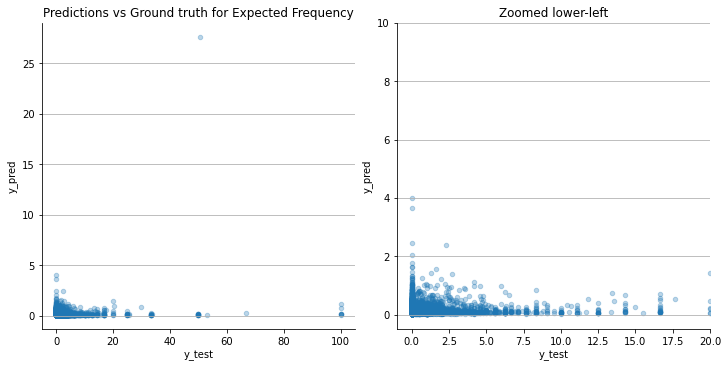

In [30]:
fig, axs = plt.subplots(constrained_layout=True, figsize=(10, 5), ncols=2)
ax=axs[0]
df_pred.groupby('y_pred').mean().reset_index().plot(kind='scatter', x='y_test', y='y_pred', alpha=0.3, ax=ax);
set_common_mpl_styles(ax, legend=False, title="Predictions vs Ground truth for Expected Frequency");
ax=axs[1]
df_pred.groupby('y_pred').mean().reset_index().plot(kind='scatter', x='y_test', y='y_pred', alpha=0.3, ax=ax);
ax.set_xlim(-1, 20)
ax.set_ylim(-0.5, 10)
set_common_mpl_styles(ax, legend=False, title="Zoomed lower-left");

In [31]:
%%time
model.score(X_train, y_train, sample_weight=df_train['Exposure'])

CPU times: user 1.53 s, sys: 3.31 ms, total: 1.53 s
Wall time: 203 ms


0.03861518042837753

In [32]:
model.score(X_test, y_test, sample_weight=df_test['Exposure'])

2.3387122481954847e-06

In [33]:
# mean poisson variance - a measure of divergence from an expected Poisson (positive >= 0 integer) output
# 0 is best, larger positive values are worse
mean_poisson_deviance(y_test, y_pred, sample_weight=df_test['Exposure'])

0.6052064235856247

# SHAP explanations

Powerful model explanation tool! https://github.com/slundberg/shap

In [34]:
explainer = shap.Explainer(model, feature_names=all_names)
# take a subset of the first 100 rows, they've been randomly shuffled already
shap_values = explainer(X_test[:100])

In [35]:
shap.initjs()

## Feature importance

* Is the fuel type predictive? Might you expect it to be?
* Does accident frequency depend upon the geographic area where the policy is taken?
* Is vehicle age or driver age more predictive of accident frequency?

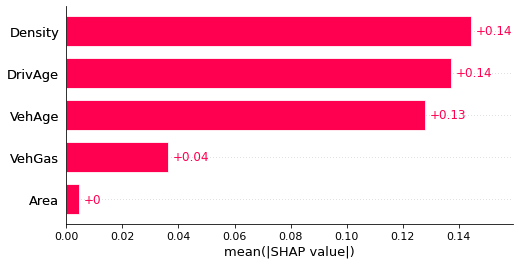

In [36]:
shap.plots.bar(shap_values)

## Force plots

A force plot explains a single prediction. Blue means "predict lower value" (i.e. fewer accidents), red means "make prediction larger" (i.e. expect more accidents). These contributions are added to come up with the final estimate (in this case a non-transformed number which is hard to explain, so ignore the bold item).

How do the following explanations feel? What story might you tell yourself? Can you imagine this being helpful when debugging?

In [37]:
#import numpy as np
#np.exp(-2.55) # we can explain the negative values shown in SHAP as frequencies

In [38]:
shap.plots.force(shap_values[3])

In [39]:
shap.plots.force(shap_values[4])

In [40]:
shap.plots.force(shap_values[6])

## Swarm plots

Low values (blue) for BonusMalus mean that the SHAP impact is negative (left), so it brings down the expected frequency of accident. Red values (high) increase the SHAP impact, raising the estimate of accident frequency.

What does a red value mean for Vehicle Age? How does this impact predicted accident frequency?

What does a red value mean for Vehicle Power? How does this impact predicted accident frequency?

What does it means for the red and blue values to overlap for Area? We see something similar for Vehicle Gas (fuel) but more spread out - does that tell us more or less?

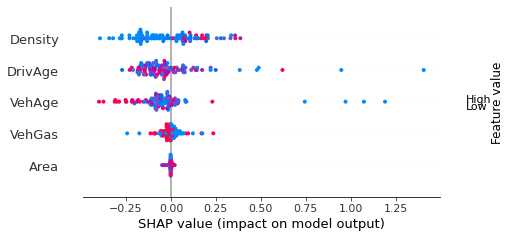

In [41]:
shap.plots.beeswarm(shap_values)

# End of Notebook